In [1]:
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from statistics import mean
from scipy import integrate
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
import statistics
import copy
from pandas import *
import imageio
import moviepy.editor as mp
import matplotlib.colors as colors

In [2]:
## acc voltage to real units conversion factor
## [y1,x1,z1, y2,x2,z2]
conv_12 = [0.0064729,0.0061162,0.006218144,0.00601427,0.00601427,0.00601427]
conv_57  = [0.0328, 0.0325, 0.0322, 0.0324, 0.0328, 0.0327]
# positions 
z = [-5]*12 + [-7]*12 + [-3]*12 # depth 
r = [6,-6,10,-10,8,-8,12,-12,7,-7,11,-11]*3 # radial 

In [242]:
## This script is created for velocity flow field measurement 
## for a single angle experiment we need 18 files to compute the profile

In [3]:
def pack(import_file_name, col_list, conv): # pack csv data to arrays 
    # import data using pandas
    col = ['Time', 'Channel A', 'Channel B', 'Channel C','Channel E','Channel F','Channel G'] # define columns
    data_pd = pd.read_csv(import_file_name, usecols = col_list)   # array in pandas
    # create empty output data pack 
    # data structure: [time, channel_a, channel_b, channel_c,...]
    output_datapack = np.linspace(0,0,np.size(col_list)).tolist()
    # conversion to str list
    for i in range(np.size(col_list)):
        output_datapack[i] = data_pd[col[i]][1:].tolist() 
        if i == 0: # time
            output_datapack[i] = [float("{0:.6f}".format(float(j)*1000)) for j in output_datapack[i]] # convert to float
        else:
            output_datapack[i] = [float(j) for j in output_datapack[i]]
            zero = mean(output_datapack[i][20:200]) # baseline for shifting and aligning "zero" accelerations to zero
            output_datapack[i] = [float(j-zero)/conv[i-1] for j in output_datapack[i]] # voltage to acceleration conversion
            #output_datapack[i] = [abs(j) for j in output_datapack[i]] # making all channel abs 
#             index = find_onset(output_datapack[i])
#             output_datapack[i][0:index] = np.linspace(0,0,index)
    return output_datapack

def align(data, time_cutoff):
    time_cutoff = [t for t in time_cutoff for _ in range(2)] # extend array 
    for i in range(np.shape(data)[0]):
        data[i][0] = [t - time_cutoff[i] for t in data[i][0]] # make time adjustment s.t. time is shifted to impact time
        data[i][0] = [float("{:.2f}".format(t)) for t in data[i][0] if t >= 0] # pop out negative values 
        data[i][0] = [float("{:.2f}".format(t-data[i][0][0])) for t in data[i][0]] # make sure impact time is zero
        for j in range(1,np.shape(data)[1]):
            data[i][j] = data[i][j][(len(data[i][j])-len(data[i][0])):] # align acc values 
    return data

def integrate_accel(channel, Time):
    velocity = np.zeros(np.size(Time)).tolist()
    running_sum = 0
    for i in range(np.size(Time)-1):
        dv = 0.5*((channel[i])+(channel[i+1]))*((Time[i+1]-Time[i])/1000)
        running_sum += dv
        velocity[i] = running_sum
        velocity[i+1] = running_sum
    return velocity

def integrate(data):
    velocity = copy.deepcopy(data)
    for i in range(np.shape(data)[0]):
        for j in range(1,np.shape(data)[1]):
            velocity[i][j] = integrate_accel(data[i][j][0:2000],data[i][0][0:2000])
            velocity[i][0] = velocity[i][0][0:2000]
    return velocity 

def create_gv(data, iterations, sp, fps, angle):
    # Create the GIF Video writer
    writer = imageio.get_writer(str(angle)+"gf.gif", mode='I', duration=1/fps)
    for i in range(0,iterations,sp):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        plt.text(-1.5,-7.5, r"$\theta_i=$"+str(angle)+r"$^\circ$", fontsize = 8)
        plt.text(-3,-8.7, 'Time: '+str("%.2f" %data[0][0][i])+'ms', fontsize=8) # text time
        # draw impact point
        plt.quiver(0,0,np.cos(angle*np.pi/180),-np.sin(angle*np.pi/180),scale=7,color='red')
        plt.plot(0,0,'o',color='red',markersize=12)
        # draw surface
        y = np.linspace(0,0,200)
        x = np.linspace(-25,25,200)
        plt.plot(x,y,linewidth=10,color='grey',alpha=0.5)
        # draw points
        plt.plot(r,z,'o',markersize=0.5,color='black')
        cm = matplotlib.cm.PuBu
        width = 0.006
        vel_index = 0 
        for j in range(len(r)):
            if j%2 == 0:
                # compute v/vmax 
                m1 = np.sqrt(data[vel_index][2][i]**2 + data[vel_index][1][i]**2)/max([np.sqrt(a**2 + b**2) for a,b in zip(data[vel_index][2],data[vel_index][1])])
                # draw quiver 
                plt.quiver(r[j],z[j], data[vel_index][2][i], data[vel_index][1][i], scale = 0.2, color = cm(m1), width = width)
            else:
                m1 = np.sqrt(data[vel_index][5][i]**2 + data[vel_index][4][i]**2)/max([np.sqrt(a**2 + b**2) for a,b in zip(data[vel_index][5],data[vel_index][4])])
                plt.quiver(r[j],z[j], -data[vel_index][5][i], data[vel_index][4][i], scale = 0.2, color = cm(m1), width = width)
                vel_index += 1
            plt.ylim(-10,0)
            plt.xlim(-15,15)
            plt.xlabel("R (cm)", fontsize = 15)
            plt.ylabel("Z (cm)", fontsize = 15)

            # color bar settings
            norm = matplotlib.colors.Normalize()
            mag = np.linspace(0,1,100)
            norm.autoscale(mag)
            scale_length = np.sqrt(2)  # Length of the scale bar in your desired units
            scale_x = 6  # x-coordinate of the scale bar's starting point
            scale_y = -8.2  # y-coordinate of the scale bar's starting point

            axs[g * 3 + t].arrow(scale_x, scale_y, scale_length, 0, width=0.1, color='orange')  # Plotting the scale bar
            axs[g * 3 + t].text(scale_x + scale_length/2, scale_y - 1.2, '0.01 m/s', ha='center', fontsize=7)  # Adding label

            cm = matplotlib.cm.PuBu
            sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
            sm.set_array([])
        fig.colorbar(sm,shrink=0.4,label=r'$v / |v_{max}|$')

        plt.savefig("temp.png", dpi=400, bbox_inches='tight')
        plt.close()  # Close the figure to free up memory
        # Read the temporary image and append it to the GIF
        image = imageio.imread("temp.png")
        writer.append_data(image)
        print(str("{:.2f}".format(i*100/iterations))+"%"+" "+"done", end='\r')
    # Close the GIF writer
    writer.close()
    ## now save a movie
    # Load the GIF file
    gif_path = str(angle)+"gf.gif"
    clip = mp.VideoFileClip(gif_path)
    # Set the output file path and format
    output_path = str(angle)+"movie.mp4"
    # Set the video parameters
    codec = 'mpeg4'  # Video codec (e.g., H.264)
    bitrate = '10M'  # Target bitrate (e.g., 10 Mbps)
    # Convert the GIF to MP4 with increased quality
    clip.write_videofile(output_path, codec=codec, bitrate=bitrate, fps=fps)
    
    
def create_comp_graph(pulse_angle_list, angle_list, time_list):
    fig, axs = plt.subplots(3, 3, figsize=(10.3, 4), sharex=True, sharey=True)
    gs = fig.add_gridspec(3, 3, hspace=0, wspace=0)
    axs = axs.flatten()
    for t in range(np.shape(time_list)[0]):
        t1 = time_list[t]
        for g in range(np.shape(angle_list)[0]):
            axs[g * 3 + t].set_ylim(-10, 1)
            axs[g * 3 + t].set_xlim(-14.5, 14.5)
            data = pulse_angle_list[g]
            axs[g * 3 + t].set_aspect('equal')
            axs[g * 3 + t].text(-2, -4.7, r"$\theta_i=$" + str(angle_list[g]) + r"$^\circ$", fontsize=9)
            axs[g * 3 + t].text(-4.5, -7, 'Time: ' + str("%.2f" % data[0][0][t1]) + 'ms', fontsize=9)
            axs[g * 3 + t].quiver(0, 0, np.cos(angle_list[g] * np.pi / 180), -np.sin(angle_list[g] * np.pi / 180), scale=7, color='red')
            if angle_list[g] == 20:
                axs[g * 3 + t].quiver(0, 0, np.cos(16 * np.pi / 180), np.sin(16 * np.pi / 180), scale=7/(46/100), color='blue')
            axs[g * 3 + t].plot(0, 0, 'o', color='red', markersize=6)
            y = np.linspace(0, 0, 200)
            x = np.linspace(-25, 25, 200)
            axs[g * 3 + t].plot(x, y, linewidth=3, color='grey', alpha=0.5)
            axs[g * 3 + t].plot(r, z, 'o', markersize=0.5, color='black')
            
            scale_length = np.sqrt(2)  # Length of the scale bar in your desired units
            scale_x = 6  # x-coordinate of the scale bar's starting point
            scale_y = -8.2  # y-coordinate of the scale bar's starting point

            axs[g * 3 + t].arrow(scale_x, scale_y, scale_length, 0, width=0.1, color='orange')  # Plotting the scale bar
            axs[g * 3 + t].text(scale_x + scale_length/2, scale_y - 1.2, '0.01 m/s', ha='center', fontsize=7)  # Adding label

            cm = matplotlib.cm.PuBu
            width = 0.006
            vel_index = 0
            for j in range(len(r)):
                if j % 2 == 0:
                    m1 = np.sqrt(data[vel_index][2][t1] ** 2 + data[vel_index][1][t1] ** 2) / max([np.sqrt(a ** 2 + b ** 2) for a, b in zip(data[vel_index][2], data[vel_index][1])])
                    axs[g * 3 + t].quiver(r[j], z[j], data[vel_index][2][t1], data[vel_index][1][t1], scale=0.2, color=cm(m1), width=width)
                else:
                    m1 = np.sqrt(data[vel_index][5][t1] ** 2 + data[vel_index][4][t1] ** 2) / max([np.sqrt(a ** 2 + b ** 2) for a, b in zip(data[vel_index][5], data[vel_index][4])])
                    axs[g * 3 + t].quiver(r[j], z[j], -data[vel_index][5][t1], data[vel_index][4][t1], scale=0.2, color=cm(m1), width=width)
                    vel_index += 1
    axs[7].set_xlabel("R (cm)", fontsize=11)
    axs[3].set_ylabel("Z (cm)", fontsize=11)

    norm = matplotlib.colors.Normalize()
    mag = np.linspace(0, 1, 100)
    norm.autoscale(mag)
    cm = matplotlib.cm.PuBu
    sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.930, 0.12, 0.008, 0.75])
    fig.colorbar(sm, label=r'$|v| / |v|_{pk}$', shrink=1, cax=cbar_ax)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('oblique_quiver_angle.png', dpi=800)

In [4]:
trial_start = 55 # serial nuumber in the file 
trial_end = 63
num_of_trials = trial_end-trial_start+1 # trial number start to end 
time_cutoff = [591.04,576.36,573.17,569.81,577.00,583.06,592.80,592.16,601.10]
acc60 = [] # store data 
# data structure 
# [t1c, t1f, t2c, t2f, ...]

## pack all the data
for i in range(num_of_trials):
    acc60.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_12)) # tc 
    acc60.append(pack('t'+str(trial_start+i)+'f'+'.csv', [0,1,2,3,4,5,6], conv_57)) # tf

In [5]:
acc60 = align(acc60,time_cutoff)
vel60 = integrate(acc60)
#create_gv(vel60, 1200, 5, 60, 60)

In [6]:
trial_start = 64 # serial nuumber in the file 
trial_end = 72
num_of_trials = trial_end-trial_start+1 # trial number start to end 
time_cutoff = [575.88,577.95,581.78,587.69,582.90,573.01,575.08,577.32,587.69]
acc40 = [] # store data 
# data structure 
# [t1c, t1f, t2c, t2f, ...]

## pack all the data
for i in range(num_of_trials):
    acc40.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_12)) # tc 
    acc40.append(pack('t'+str(trial_start+i)+'f'+'.csv', [0,1,2,3,4,5,6], conv_57)) # tf

In [7]:
acc40 = align(acc40,time_cutoff)
vel40 = integrate(acc40)

In [8]:
#create_gv(vel40, 1200, 5, 60, 40)

In [9]:
trial_start = 73 # serial number in the file 
trial_end = 81
num_of_trials = trial_end-trial_start+1 # trial number start to end 
time_cutoff = [600.0,596.2,589.2,581.5,578,579.2,582.4,595.2,594.7]
acc20 = [] # store data 
# data structure 
# [t1c, t1f, t2c, t2f, ...]

## pack all the data
for i in range(num_of_trials):
    acc20.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_12)) # tc 
    acc20.append(pack('t'+str(trial_start+i)+'f'+'.csv', [0,1,2,3,4,5,6], conv_57)) # tf

In [10]:
acc20 = align(acc20,time_cutoff)
vel20 = integrate(acc20)

In [11]:
#create_gv(vel20, 1200, 5, 60, 20)

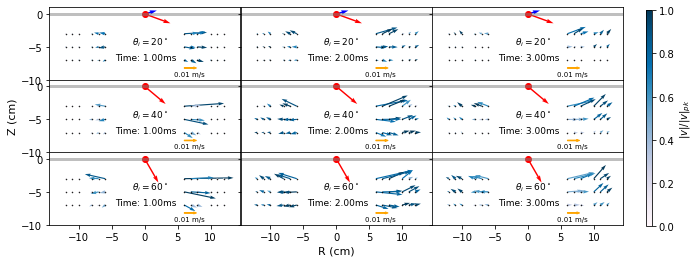

In [12]:
pulse_angle_list = [vel20,vel40,vel60]
angle_list = [20,40,60]
create_comp_graph(pulse_angle_list, angle_list, [200,400,600])

In [35]:
def create_comp_graph(pulse_angle_list, angle_list, time):
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
    gs = fig.add_gridspec(3, 1, hspace=0, wspace=0)
    axs = axs.flatten()
    t1 = time
    for g in range(np.shape(angle_list)[0]):
        axs[g].set_ylim(-10.5, 1)
        axs[g].set_xlim(-14.5, 14.5)
        data = pulse_angle_list[g]
        axs[g].set_aspect('equal')
        axs[g].text(-1.5, -5.5, r"$\theta_i=$" + str(angle_list[g]) + r"$^\circ$", fontsize=7)
        axs[g].text(-3.5, -6.7, 'Time: ' + str("%.2f" % data[0][0][t1]) + 'ms', fontsize=7)
        axs[g].quiver(0, 0, np.cos(angle_list[g] * np.pi / 180), -np.sin(angle_list[g] * np.pi / 180), scale=7, color='red')
        axs[g].plot(0, 0, 'o', color='red', markersize=6)
        y = np.linspace(0, 0, 200)
        x = np.linspace(-25, 25, 200)
        axs[g].plot(x, y, linewidth=3, color='grey', alpha=0.5)
        axs[g].plot(r, z, 'o', markersize=0.5, color='black')
        scale_length = np.sqrt(2)  # Length of the scale bar in your desired units
        scale_x = 6  # x-coordinate of the scale bar's starting point
        scale_y = -8.2  # y-coordinate of the scale bar's starting point
        axs[g].arrow(scale_x, scale_y, scale_length, 0, width=0.1, color='orange')  # Plotting the scale bar
        axs[g].text(scale_x + scale_length/2, scale_y - 1.2, '0.01 m/s', ha='center', fontsize=7)  # Adding label
        cm = matplotlib.cm.PuBu
        width = 0.006
        vel_index = 0
        axs[0].quiver(0, 0, np.cos(16 * np.pi / 180), np.sin(16 * np.pi / 180), scale=7/(46/100), color='blue')
        for j in range(len(r)):
            if j % 2 == 0:
                m1 = np.sqrt(data[vel_index][2][t1] ** 2 + data[vel_index][1][t1] ** 2) / max([np.sqrt(a ** 2 + b ** 2) for a, b in zip(data[vel_index][2], data[vel_index][1])])
                axs[g].quiver(r[j], z[j], data[vel_index][2][t1], data[vel_index][1][t1], scale=0.2, color=cm(m1), width=width)
            else:
                m1 = np.sqrt(data[vel_index][5][t1] ** 2 + data[vel_index][4][t1] ** 2) / max([np.sqrt(a ** 2 + b ** 2) for a, b in zip(data[vel_index][5], data[vel_index][4])])
                axs[g].quiver(r[j], z[j], -data[vel_index][5][t1], data[vel_index][4][t1], scale=0.2, color=cm(m1), width=width)
                vel_index += 1
            
    axs[2].set_xlabel("R (cm)", fontsize=11)
    axs[1].set_ylabel("Z (cm)", fontsize=11)

    norm = matplotlib.colors.Normalize()
    mag = np.linspace(0, 1, 100)
    norm.autoscale(mag)
    cm = matplotlib.cm.PuBu
    sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.790, 0.12, 0.008, 0.75])
    fig.colorbar(sm, label=r'$|v| / |v|_{pk}$', shrink=1, cax=cbar_ax)
    plt.subplots_adjust(wspace=0, hspace=0)

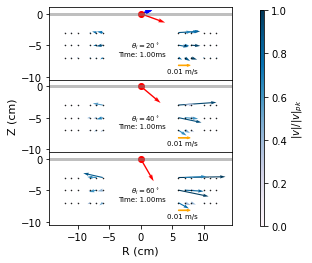

In [36]:
create_comp_graph(pulse_angle_list, angle_list, 200)

In [37]:
def create_comp_gv(pulse_angle_list,angle_list,iterations, sp, fps):
    # Create the GIF Video writer
    writer = imageio.get_writer('angle_comp'+"gf.gif", mode='I', duration=1/fps)
    for i in range(0,iterations,sp):
        create_comp_graph(pulse_angle_list, angle_list, i)
        plt.savefig("temp.png", dpi=400, bbox_inches='tight')
        plt.close()  # Close the figure to free up memory
        # Read the temporary image and append it to the GIF
        image = imageio.imread("temp.png")
        writer.append_data(image)
        print(str("{:.2f}".format(i*100/iterations))+"%"+" "+"done", end='\r')
    # Close the GIF writer
    writer.close()
    ## now save a movie
    # Load the GIF file
    gif_path = 'angle_comp'+"gf.gif"
    clip = mp.VideoFileClip(gif_path)
    # Set the output file path and format
    output_path = 'angle_comp'+"movie.mp4"
    # Set the video parameters
    codec = 'mpeg4'  # Video codec (e.g., H.264)
    bitrate = '10M'  # Target bitrate (e.g., 10 Mbps)
    # Convert the GIF to MP4 with increased quality
    clip.write_videofile(output_path, codec=codec, bitrate=bitrate, fps=fps)

In [38]:
create_comp_gv(pulse_angle_list,angle_list,1200, 5, 60)

t:   1%|▍                             | 4/288 [00:00<00:08, 35.34it/s, now=None]

Moviepy - Building video angle_compmovie.mp4.
Moviepy - Writing video angle_compmovie.mp4



Moviepy - Done !
Moviepy - video ready angle_compmovie.mp4
